## AlexNet Model Training Porocess

### Import libraries

In [1]:
import numpy as np
import keras
import tensorflow as tf
from matplotlib import pyplot as plt
from time import time
import warnings
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
%matplotlib inline

### Dataset paths

In [2]:
train_path = 'new_augmentation/train'
valid_path = 'new_augmentation/val'
test_path = 'new_augmentation/test'

### Training classes

In [3]:
train_classes = os.listdir(train_path)

### Training batch sizes

In [4]:
train_batch_size = 16
test_batch_size = 16
valid_batch_size = 16

### Training samples

In [5]:

# Count the number of samples in each directory
train_n = sum([len(files) for r, d, files in os.walk(train_path)])
test_n = sum([len(files) for r, d, files in os.walk(test_path)])
valid_n = sum([len(files) for r, d, files in os.walk(valid_path)])

print(f'Training samples: {train_n}')
print(f'Test samples: {test_n}')
print(f'Validation samples: {valid_n}')

Training samples: 2387
Test samples: 907
Validation samples: 906


In [6]:
train_n = 1212
test_n = 458
valid_n = 457

### Training steps (per epoch)

In [7]:
train_steps = train_n//train_batch_size
valid_steps = valid_n//valid_batch_size
test_steps = test_n//test_batch_size

### Epochs

In [8]:
epochs = 30

### Generate batches

In [9]:
train_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(train_path, target_size=(128,128), classes=train_classes, batch_size=train_batch_size)
valid_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(valid_path, target_size=(128,128), classes=train_classes, batch_size=valid_batch_size)
test_batches = tf.keras.preprocessing.image.ImageDataGenerator().flow_from_directory(test_path, target_size=(128,128), classes=train_classes, batch_size=test_batch_size)

Found 2387 images belonging to 9 classes.
Found 906 images belonging to 9 classes.
Found 907 images belonging to 9 classes.


### Base model (AlexNet)

#### Training from scratch

In [10]:
base_model = tf.keras.applications.  (include_top=False,
   weights="imagenet",
    pooling='avg')

In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
output =  tf.keras.layers.Dense(len(train_classes), activation='softmax')(base_model.output)
new_model = tf.keras.Model(base_model.input, output)

### Set early stopping
Avoids model overfitting

In [13]:
es_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    verbose=1,
    patience=2,
    mode='max',
    restore_best_weights=True
)

### Generate new model

In [14]:
new_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False,
    label_smoothing=0,
    reduction="auto",
    name="categorical_crossentropy"), metrics=['accuracy'])

### Training

In [15]:
history = new_model.fit_generator(train_batches, validation_data=valid_batches, validation_steps=valid_steps, steps_per_epoch=train_steps, epochs=epochs,callbacks=[es_callback])

Epoch 1/30
75/75 [==============================] - 187s 2s/step - loss: 1.0639 - accuracy: 0.6683 - val_loss: 2.9390 - val_accuracy: 0.4397
Epoch 2/30
75/75 [==============================] - 152s 2s/step - loss: 0.2092 - accuracy: 0.9334 - val_loss: 2.9114 - val_accuracy: 0.4710
Epoch 3/30
75/75 [==============================] - 153s 2s/step - loss: 0.1018 - accuracy: 0.9775 - val_loss: 2.7677 - val_accuracy: 0.5379
Epoch 4/30
75/75 [==============================] - 151s 2s/step - loss: 0.0676 - accuracy: 0.9892 - val_loss: 3.3456 - val_accuracy: 0.4554
Epoch 5/30
75/75 [==============================] - 155s 2s/step - loss: 0.0510 - accuracy: 0.9916 - val_loss: 2.5536 - val_accuracy: 0.5491
Epoch 6/30
75/75 [==============================] - 150s 2s/step - loss: 0.0379 - accuracy: 0.9950 - val_loss: 2.5098 - val_accuracy: 0.5670
Epoch 7/30
75/75 [==============================] - 147s 2s/step - loss: 0.0243 - accuracy: 0.9992 - val_loss: 2.8009 - val_accuracy: 0.5268
Epoch 8/30
75

### Evaluate training process

In [16]:
results = new_model.evaluate_generator(train_batches, train_steps)
results

[0.022336063906550407, 0.996666669845581]

#### Loss function

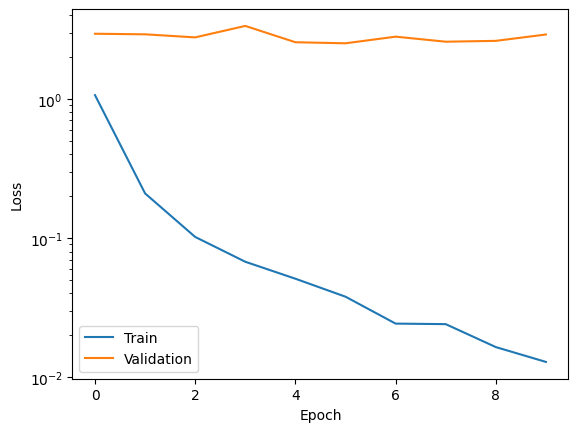

In [17]:
plt.semilogy(history.epoch,  history.history['loss'], label='Train')
plt.semilogy(history.epoch,  history.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Accuracy function

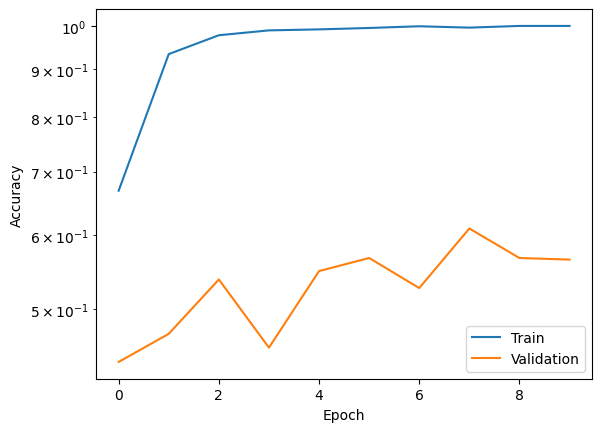

In [18]:
plt.semilogy(history.epoch, history.history['accuracy'], label='Train')
plt.semilogy(history.epoch, history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [19]:
Y_train_pred =new_model.predict_generator(train_batches,train_steps)

In [20]:
y_train_pred = np.argmax(Y_train_pred, axis=1)

In [21]:
print(len(train_batches.classes))
print(len(y_train_pred))

2387
1200


#### Confusion matrix

In [22]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming train_batches is your training data generator
# Make predictions on the training set
y_train_pred = new_model.predict(train_batches, steps=train_batches.samples // train_batches.batch_size + 1)
y_train_pred_classes = np.argmax(y_train_pred, axis=1)

# Ensure the lengths match
assert len(train_batches.classes) == len(y_train_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm_train = confusion_matrix(train_batches.classes, y_train_pred_classes)

print(cm_train)

# cm_train = confusion_matrix(train_batches.classes, y_train_pred)

150/150 [==============================] - 219s 1s/step
[[66 69 32 27 16 66 51 39 30]
 [64 52 27 39 17 62 58 34 38]
 [31 29 19 16  8 44 17 21 13]
 [26 29 15 20  7 37 24 18 25]
 [20 13  4 12  4 17 14  7  9]
 [51 71 39 35 16 71 41 34 38]
 [53 50 29 27 16 47 44 18 17]
 [38 34 16 12  7 25 36 12 22]
 [40 45 17 13  9 31 16 19 12]]


Text(0.5, 135.7222222222222, 'Predicted label')

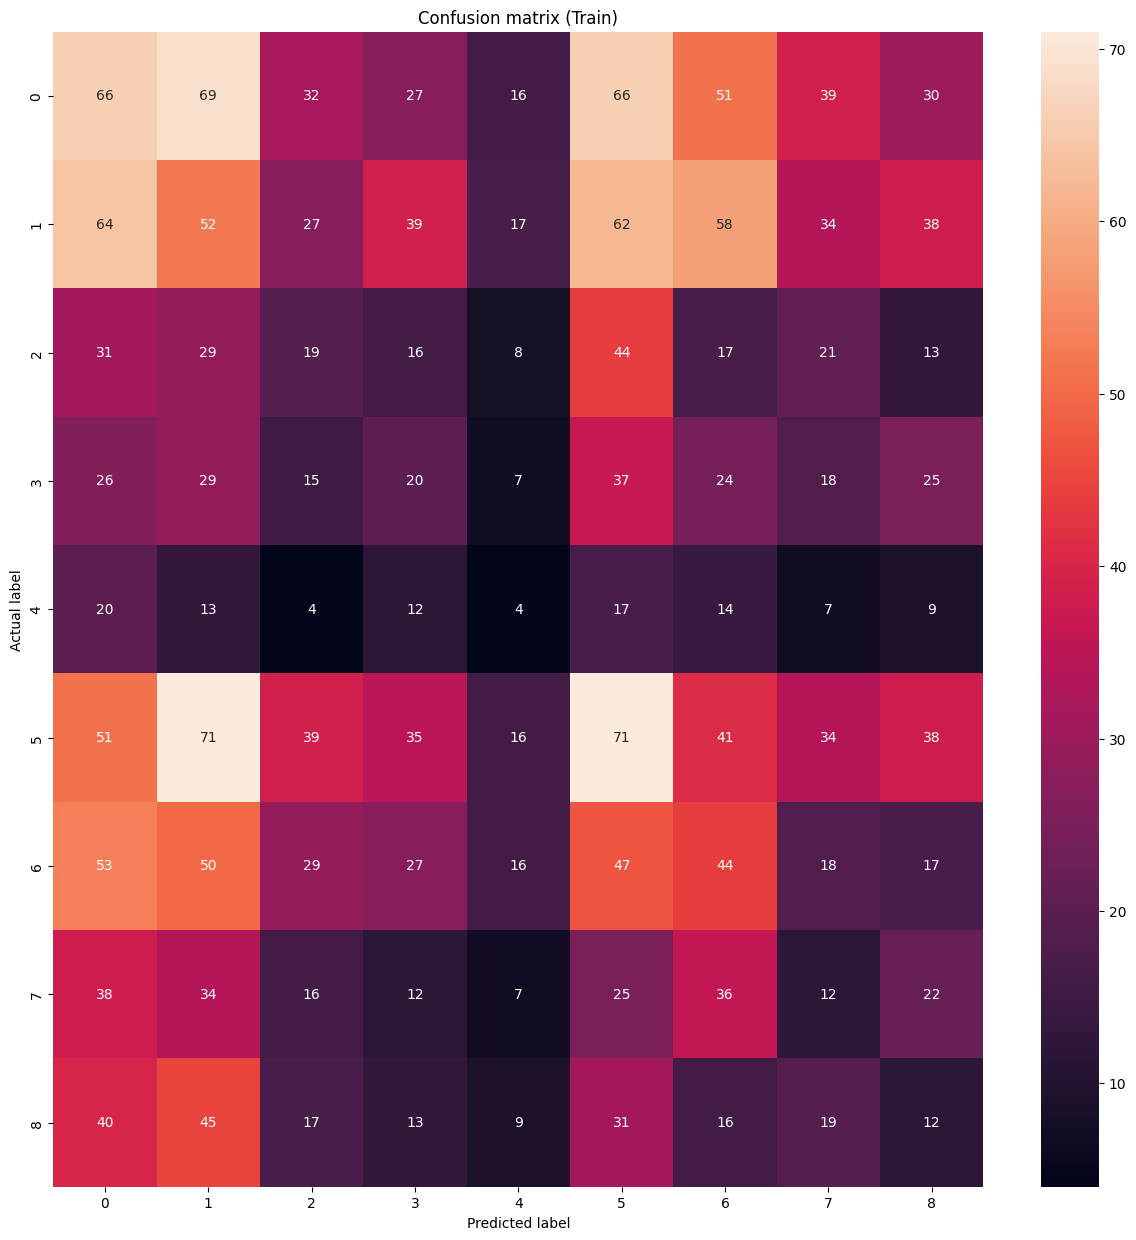

In [23]:
plt.figure(figsize=(15,15))
sns.heatmap(cm_train, annot=True, fmt="d")
plt.title('Confusion matrix (Train)')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Model testing

In [24]:
Y_pred =new_model.predict_generator(test_batches,test_steps)

In [25]:
y_pred = np.argmax(Y_pred, axis=1)

In [26]:
# cm = confusion_matrix(test_batches.classes, y_pred)

from sklearn.metrics import confusion_matrix
import numpy as np

# Assuming test_batches is your test data generator
# Make predictions on the test set
y_pred = new_model.predict(test_batches, steps=test_batches.samples // test_batches.batch_size + 1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Ensure the lengths match
assert len(test_batches.classes) == len(y_pred_classes), "Mismatch in number of samples"

# Compute the confusion matrix
cm = confusion_matrix(test_batches.classes, y_pred_classes)

print(cm)

57/57 [==============================] - 80s 1s/step
[[15  8 13  6  0 28 13  9  9]
 [13 10  7  5  0 30 14  8 14]
 [14 10  9  2  0 31 13 10 11]
 [19 11 12  5  0 24  6  9 15]
 [12 11 19  6  0 23 15  5 10]
 [19  9 15  4  0 25 10 14  5]
 [23  9  9 10  0 24  8  3 14]
 [22 10  7 10  0 22 10  7 13]
 [16 13  6  6  0 33  7  4 16]]


Text(0.5, 135.7222222222222, 'Predicted label')

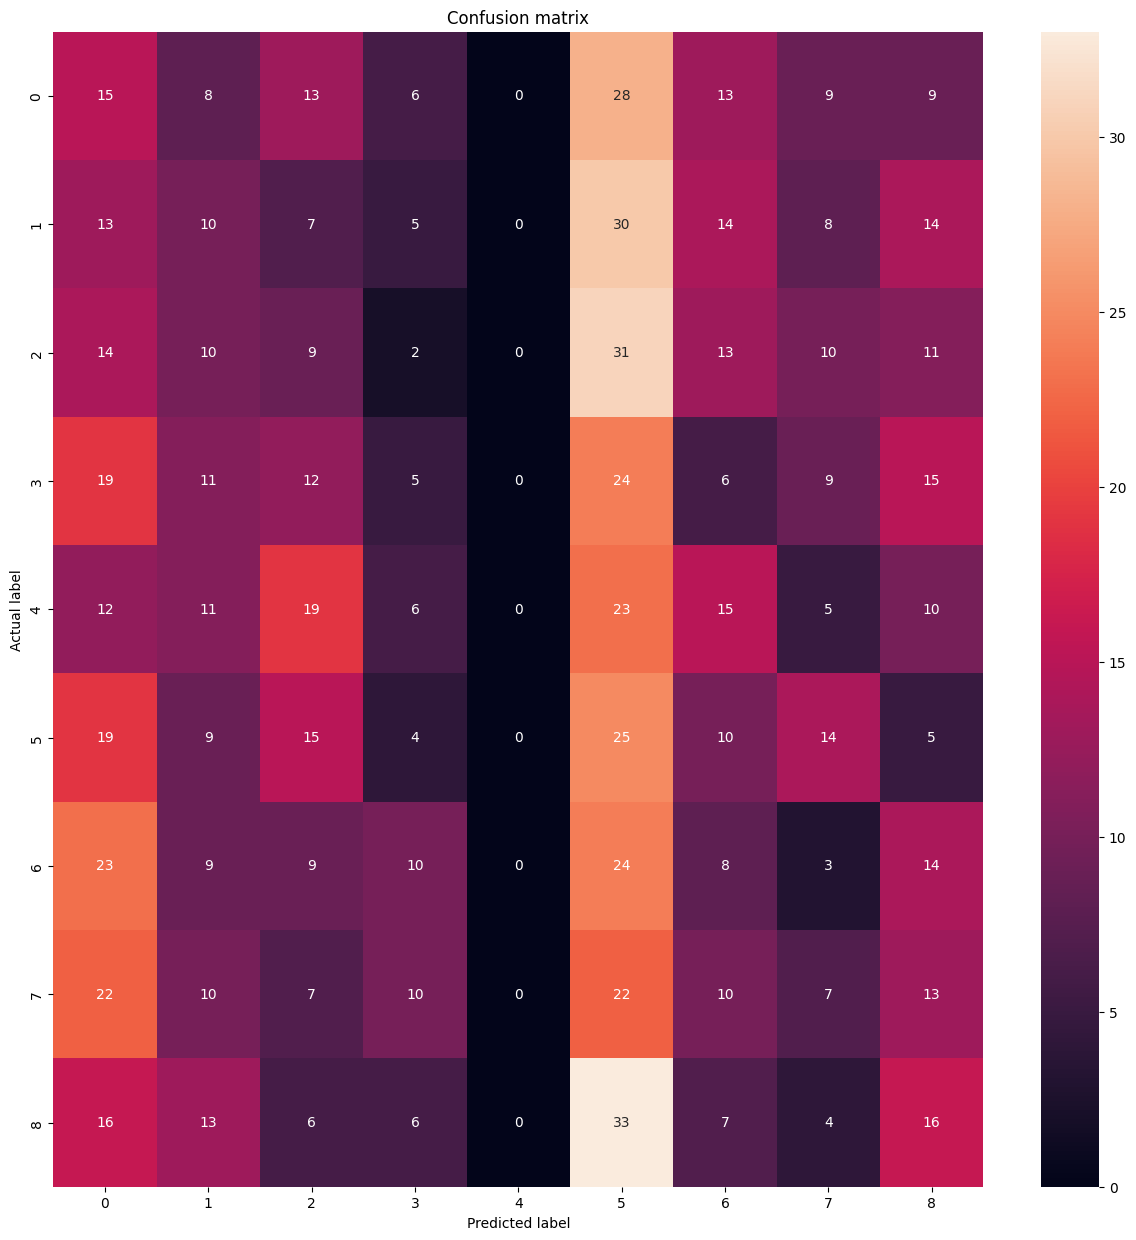

In [27]:
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

### Save model

In [28]:
new_model.save('vgg16_V1new.h5')